# 只做ESM sampling - 2D

## ESM introduction (待修改)

### Dataset
- **Data distribution**：1D Gaussian 混合分佈  
  $$p(x) = 0.5\,\mathcal{N}(-2,1^2) + 0.5\,\mathcal{N}(3,0.5^2) $$
- **Sample**：
  - Train set：4000 筆樣本  
  - Validation set：1000 筆樣本  
  - Test set：1000 筆樣本  
  三組樣本互不重疊。

---

### ESM Loss 定義
顯式 Score Matching (ESM) 損失函數：
$$
\mathcal{L}_{\text{ESM}}(x)
= \frac{1}{2}\|s_\theta(x)\|^2 + \operatorname{div}s_\theta(x)
$$
在一維下，散度為：
$$
\operatorname{div}s_\theta(x) = \frac{d s_\theta(x)}{dx}
$$

---

### 訓練與評估流程
1. **Train loss**：用於反向傳遞與更新參數。  
2. **Validation loss**：僅量測模型泛化能力，不更新參數。  
3. **Test loss**：最終評估模型表現。  
4. **視覺化**：
   - Train / Validation loss 曲線
   - Learned score vs True score 比對圖

---

### 目標
觀察模型在 toy 資料上能否學出真實的 score function  
（即 $\nabla_x \log p(x)$）並檢視其收斂行為。


## Experiment

In [1]:
import math, torch, torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt

torch.manual_seed(0)
device = torch.device('cpu')

In [8]:
def mvn_logpdf(x, mean, cov):
    # x: (B,2); mean:(2,); cov:(2,2)
    L = torch.linalg.cholesky(cov)                          # cov = L L^T
    y = torch.cholesky_solve((x-mean).unsqueeze(-1), L)     # (B,2,1)
    quad = ((x-mean).unsqueeze(-1) * y).sum(dim=(1,2))      # (B,)
    logdet = 2.0 * torch.log(torch.diag(L)).sum()
    d = x.size(-1)
    return -0.5*(d*math.log(2*math.pi) + logdet + quad)

# Two-component GMM
m1 = torch.tensor([-2.0, 0.0], device=device)
S1 = torch.tensor([[1.0, 0.3],[0.3, 1.2]], device=device)
m2 = torch.tensor([ 3.0, 3.0], device=device)
S2 = torch.tensor([[0.6,-0.2],[-0.2, 0.7]], device=device)

def sample_data(n):
    n1 = n//2; n2 = n-n1
    x1 = torch.distributions.MultivariateNormal(m1, S1).sample((n1,))
    x2 = torch.distributions.MultivariateNormal(m2, S2).sample((n2,))
    x  = torch.cat([x1,x2], dim=0)
    return x.to(device)

def logp_x(x):
    lp1 = mvn_logpdf(x, m1, S1)
    lp2 = mvn_logpdf(x, m2, S2)
    m = torch.maximum(lp1, lp2)
    return m + torch.log(0.5*torch.exp(lp1-m) + 0.5*torch.exp(lp2-m))

@torch.no_grad()
def true_score(x):
    with torch.enable_grad():
        x = x.clone().requires_grad_(True)
        lp = logp_x(x)
        (g,) = torch.autograd.grad(lp.sum(), x)  # ∇_x log p(x)
    return g


In [9]:
class ScoreMLP2D(nn.Module):
    def __init__(self, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden), nn.SiLU(),
            nn.Linear(hidden, hidden), nn.SiLU(),
            nn.Linear(hidden, 2)
        )
    def forward(self, x): return self.net(x)

lr=5e-4
weight_decay=1e-4
model=ScoreMLP2D().to(device)
opt = torch.optim.Adam(
    model.parameters(),
    lr=lr,
    weight_decay=weight_decay,
    betas=(0.9, 0.999),
    eps=1e-8,
)

In [10]:
def divergence_exact(x, s):
    div_terms = []
    for i in range(2):
        (gi,) = torch.autograd.grad(s[:, i].sum(), x, create_graph=True)
        div_terms.append(gi[:, i:i+1])
    div = torch.cat(div_terms, dim=1).sum(dim=1, keepdim=True)  # (B,1)
    return div

def esm_loss(x):
    x = x.detach().requires_grad_(True)
    s = model(x)                                 # (B,2)
    div = divergence_exact(x, s)                  # (B,1)
    loss = (0.5*(s**2).sum(dim=1, keepdim=True) + div).mean()
    return loss

@torch.no_grad()
def esm_loss_eval(x):
    model.eval()
    with torch.enable_grad():                    
        x = x.clone().requires_grad_(True)
        s = model(x)
        (div,) = divergence_exact(x, s),         
        loss = (0.5*(s**2).sum(dim=1, keepdim=True) + div).mean().item()
    return loss

## Main

In [11]:
train_x = sample_data(8000)
val_x   = sample_data(2000)
test_x  = sample_data(2000)

BATCH=1024
STEPS=3000
train_hist, val_hist = [], []

for step in range(1, STEPS+1):
    model.train()
    idx = torch.randint(0, len(train_x), (BATCH,))
    xb = train_x[idx]
    loss = esm_loss(xb)
    opt.zero_grad(set_to_none=True)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    opt.step()

    if step%50==0:
        val = esm_loss_eval(val_x)
        train_hist.append(loss.item()); val_hist.append(val)
        print(f"step {step:4d} | train {loss.item():.4f} | val {val:.4f}")

step   50 | train -0.7606 | val -0.7534
step  100 | train -1.0367 | val -1.0412
step  150 | train -1.2245 | val -1.2241
step  200 | train -1.2213 | val -1.2545
step  250 | train -1.2370 | val -1.2709
step  300 | train -1.2304 | val -1.2885
step  350 | train -1.2746 | val -1.2901
step  400 | train -1.3476 | val -1.3073
step  450 | train -1.3089 | val -1.2966
step  500 | train -1.3397 | val -1.3155
step  550 | train -1.3327 | val -1.3136
step  600 | train -1.3165 | val -1.3280
step  650 | train -1.3098 | val -1.3312
step  700 | train -1.3279 | val -1.3195
step  750 | train -1.2959 | val -1.3366
step  800 | train -1.3856 | val -1.3217
step  850 | train -1.2478 | val -1.3373
step  900 | train -1.3847 | val -1.3402
step  950 | train -1.3948 | val -1.3287
step 1000 | train -1.2951 | val -1.3420
step 1050 | train -1.3770 | val -1.3194
step 1100 | train -1.3806 | val -1.3409
step 1150 | train -1.2547 | val -1.3161
step 1200 | train -1.2722 | val -1.3232
step 1250 | train -1.3259 | val -1.3280


In [12]:
#### TEST
test_loss = esm_loss_eval(test_x)
print(f"\nFinal test loss = {test_loss:.4f}")


Final test loss = -1.3367


## 試著畫各種圖
* training loss/ validation loss
* score function distribution
* scatter plot

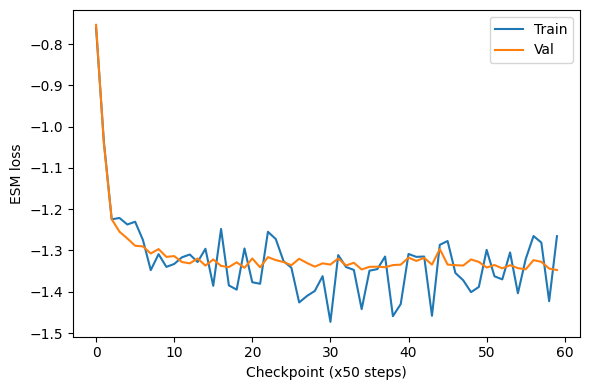

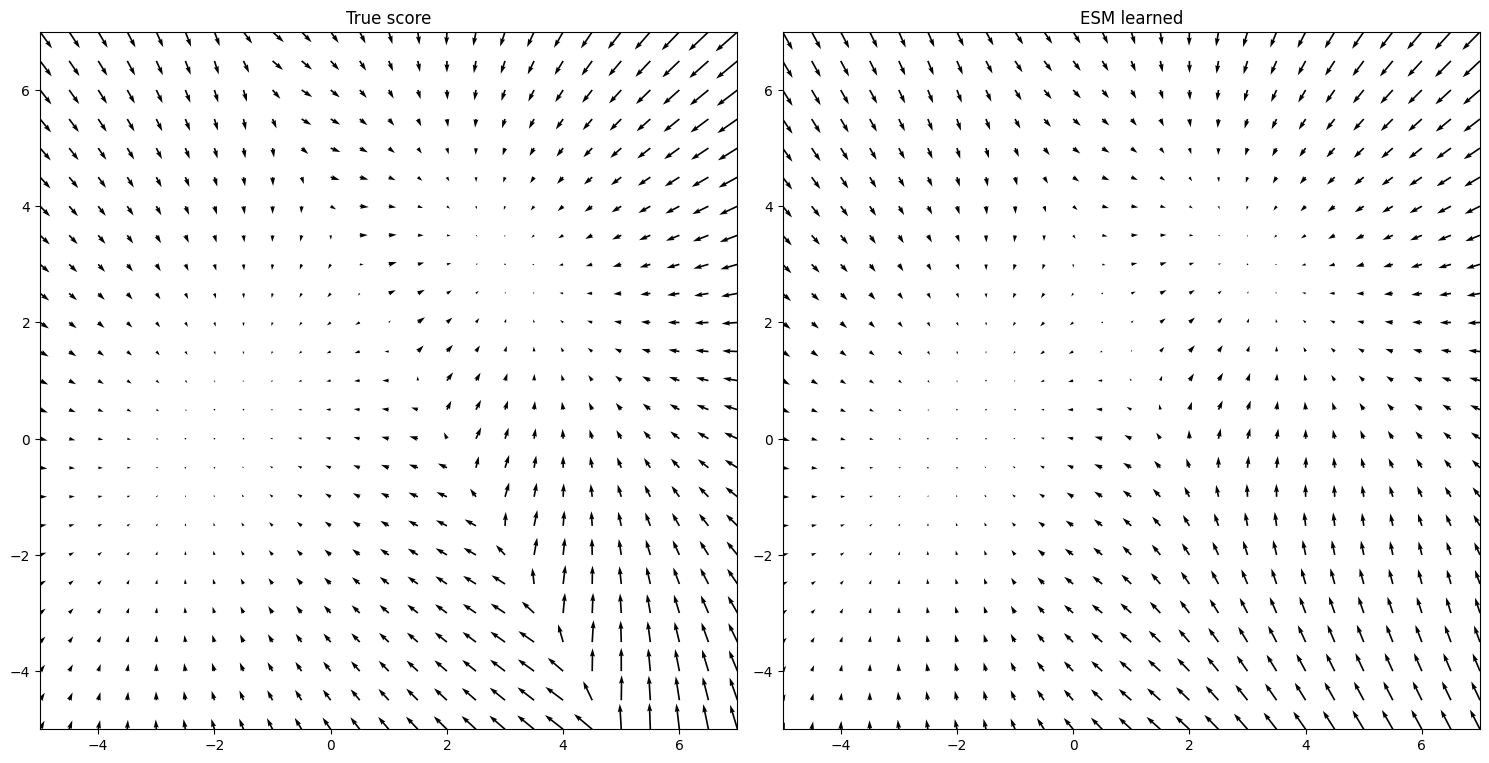

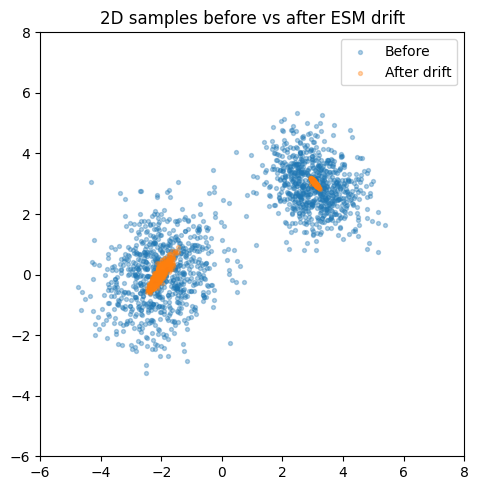

In [14]:
# (a) Loss curves
plt.figure(figsize=(6,4))
plt.plot(train_hist, label='Train'); plt.plot(val_hist, label='Val')
plt.xlabel('Checkpoint (x50 steps)'); plt.ylabel('ESM loss')
plt.legend(); plt.tight_layout(); plt.show()

# (b) Vector field: true vs learned
with torch.no_grad():
    xx, yy = torch.meshgrid(
        torch.linspace(-5, 7, 25, device=device),
        torch.linspace(-5, 7, 25, device=device),
        indexing="xy"
    )
    grid = torch.stack([xx.reshape(-1), yy.reshape(-1)], dim=1)
    s_hat = model(grid)
s_true = true_score(grid)

def quiver(ax, pts, vec, title):
    ax.quiver(pts[:,0].cpu(), pts[:,1].cpu(),
              vec[:,0].cpu(), vec[:,1].cpu(), angles='xy', scale_units='xy', scale=25)
    ax.set_title(title); ax.set_aspect('equal'); ax.set_xlim(-5,7); ax.set_ylim(-5,7)

fig, axs = plt.subplots(1,2, figsize=(15,8))
quiver(axs[0], grid, s_true, "True score")
quiver(axs[1], grid, s_hat,  "ESM learned")
plt.tight_layout(); plt.show()

# (c) Scatter: before vs after drift along learned score
@torch.no_grad()
def drift_samples(model, x, eta=0.05, steps=40):
    x = x.clone()
    for _ in range(steps):
        x += eta * model(x)
    return x

x0 = sample_data(1500)
x_after = drift_samples(model, x0, eta=0.05, steps=40)

plt.figure(figsize=(5,5))
plt.scatter(x0[:,0].cpu(), x0[:,1].cpu(), s=8, alpha=0.35, label='Before')
plt.scatter(x_after[:,0].cpu(), x_after[:,1].cpu(), s=8, alpha=0.35, label='After drift')
plt.legend(); plt.gca().set_aspect('equal'); plt.xlim(-6,8); plt.ylim(-6,8)
plt.title("2D samples before vs after ESM drift")
plt.tight_layout(); plt.show()